# Classification Origin

Papers:

https://www.semanticscholar.org/paper/Music-and-Geography%3A-Content-Description-of-Musical-G%C3%B3mez-Haro/4d48f2eaefc6a8336149e4cca1c5d2264969f223#paper-topics
https://www.geographyrealm.com/the-geography-of-music/
https://www.cambridge.org/core/journals/organised-sound/article/marsyas-a-framework-for-audio-analysis/43A5D9BCB0F7BB439E1D4D1FF4B563C2
https://archive.ics.uci.edu/dataset/315/geographical+original+of+music



In [171]:
import csv
import numpy as np
#from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE

#import matplotlib
import pandas as pd
#import matplotlib.cm as cm  # Import the colormap module
#import folium
#from scipy.spatial import Voronoi
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
#import folium
#from folium.plugins import MarkerCluster
from pytube import YouTube
import librosa
#import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from datetime import datetime, timezone
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import catboost as cb
from sklearn.metrics import ConfusionMatrixDisplay




In [172]:
music_origin_data = pd.read_csv('./data/kaggle/Music_origin.csv')
music_origin_cr_data = pd.read_csv('./data/kaggle/Music_origin_chromatic.csv')
gdf_bondaries = gpd.read_file('./data/countries/world-administrative-boundaries.shp')

music_origin_data.drop('Unnamed: 0',axis=1,inplace=True)
music_origin_cr_data.drop('Unnamed: 0',axis=1,inplace=True)

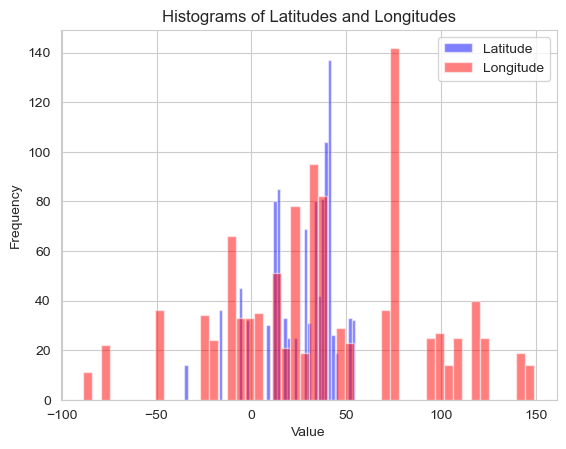

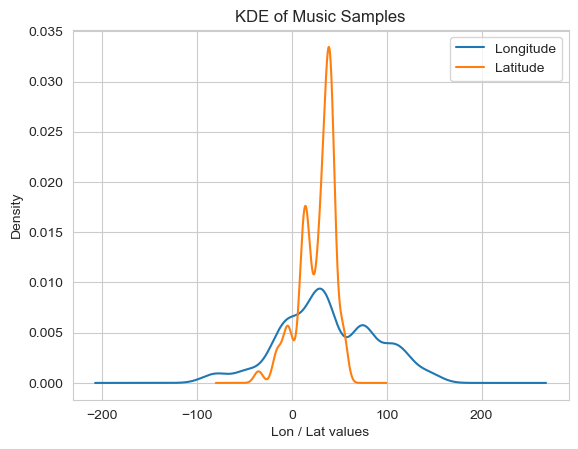

In [173]:
with open('./data/default_features_1059_tracks.txt', newline='') as inputfile:
    data = list(csv.reader(inputfile))

plt.hist(music_origin_data["Latitude"], bins=50, alpha=0.5, color='blue', label='Latitude')
plt.hist(music_origin_data["Longitude"], bins=50, alpha=0.5, color='red', label='Longitude')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histograms of Latitudes and Longitudes')
plt.savefig('./images/02_hist_lat_lon.png')
plt.show()



music_origin_data[["Longitude","Latitude"]].plot.kde()
plt.xlabel('Lon / Lat values')
plt.title('KDE of Music Samples')
plt.savefig('./images/03_KDE_lat_lon.png')
plt.show()

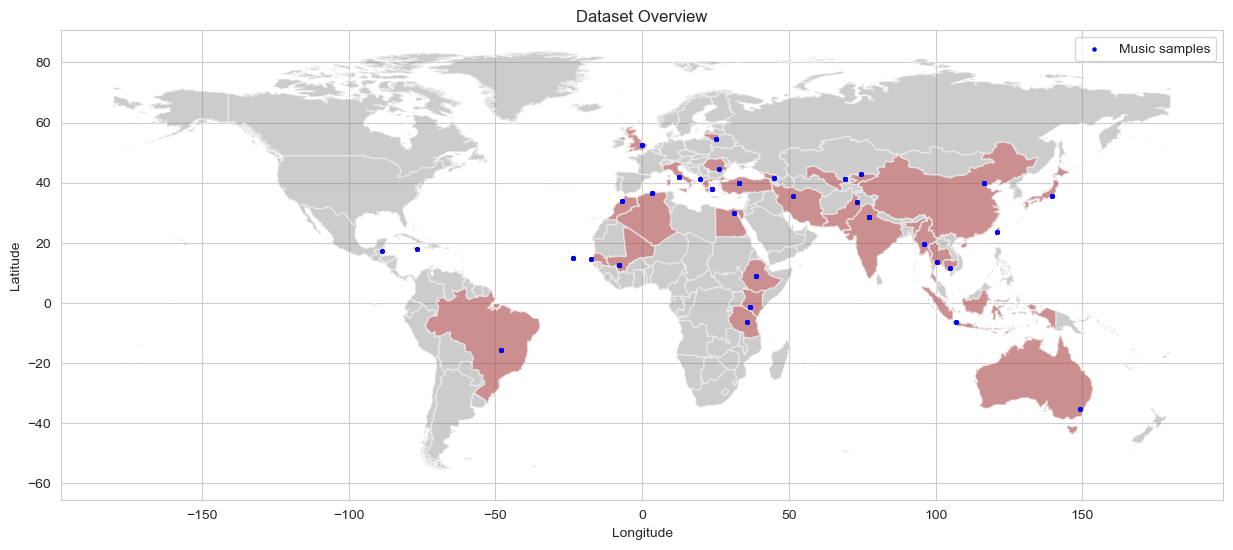

In [174]:



geometry = [Point(xy) for xy in zip(music_origin_data['Longitude'], music_origin_data['Latitude'])]
music_origin_gdf = gpd.GeoDataFrame(music_origin_data, geometry=geometry, crs="EPSG:4326")
music_origin_gdf = gpd.sjoin(music_origin_gdf, gdf_bondaries, how="left", op="within")
unmatched_points = music_origin_gdf[music_origin_gdf['iso3'].isna()].copy()

for idx, point in unmatched_points.iterrows():
    point_geom = point['geometry']
    nearest_polygon_idx = gdf_bondaries.geometry.distance(point_geom).idxmin()
    nearest_polygon_attributes = gdf_bondaries.loc[nearest_polygon_idx]
    nearest_polygon_attributes['geometry'] = point_geom
    music_origin_gdf.loc[idx, music_origin_gdf.columns.intersection(nearest_polygon_attributes.index)] = nearest_polygon_attributes

music_origin_gdf = music_origin_gdf.drop(columns=['index_right']).rename(columns={'index_left': 'index'})


plt.figure(figsize=(15,10))
music_origin_gdf_filtered = gdf_bondaries[gdf_bondaries['iso3'].isin(music_origin_gdf['iso3'])]
music_origin_gdf_filtered.plot(ax=plt.gca(), color='red', alpha=0.4, label='Shapefile')
gdf_bondaries.plot(ax=plt.gca(), color='gray', alpha=0.4, label='Shapefile')
plt.scatter(music_origin_data["Longitude"], music_origin_data["Latitude"], s=5, color = "blue",label = 'Music samples')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Dataset Overview')
plt.legend()
plt.savefig('./images/01_Dataset_overview.png')
plt.show()

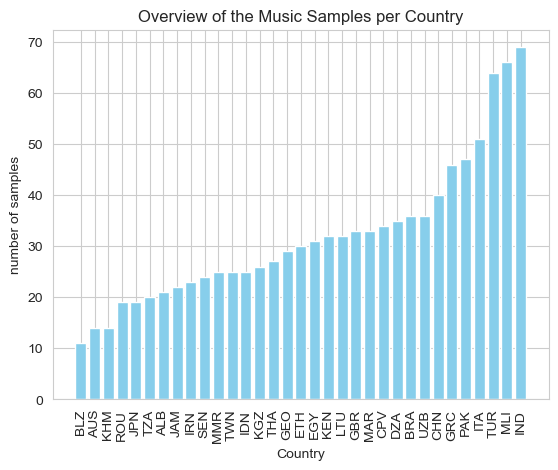

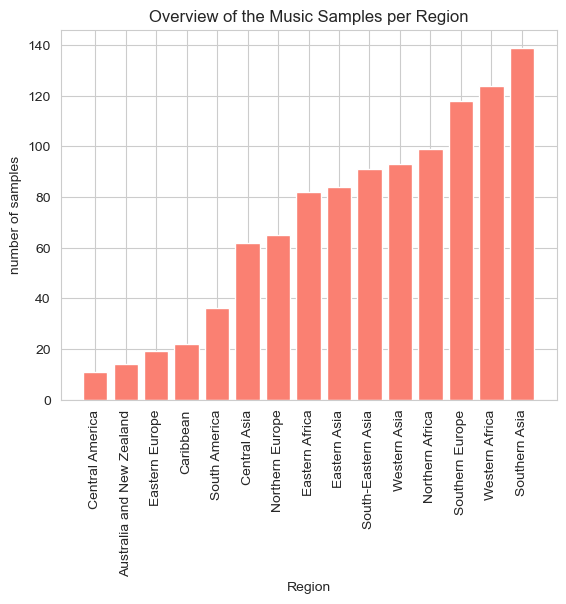

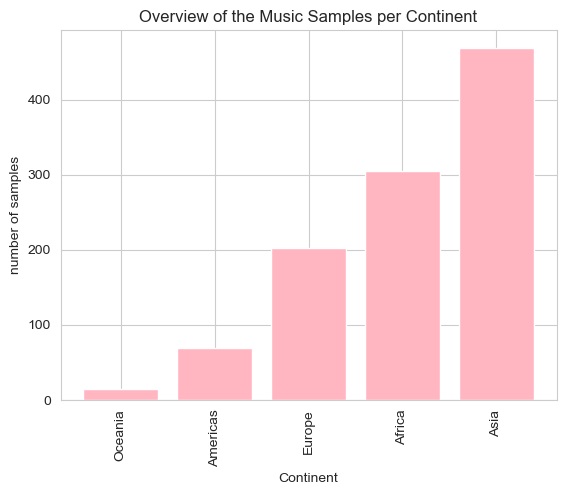

In [175]:
per_country = music_origin_gdf.groupby('iso3').nunique().reset_index().sort_values('Feature1')
plt.bar(per_country["iso3"],per_country["Feature1"], color = "skyblue")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Country")
plt.ylabel("number of samples")
plt.xlabel("Country")
plt.savefig('./images/04_Overview_music_per_country.png')
plt.show()

per_region = music_origin_gdf.groupby('region').nunique().reset_index().sort_values('Feature1')
plt.bar(per_region["region"],per_region["Feature1"], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Region")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.savefig('./images/05_Overview_music_per_region.png')
plt.show()

per_continent = music_origin_gdf.groupby('continent').nunique().reset_index().sort_values('Feature1')
plt.bar(per_continent["continent"],per_continent["Feature1"], color = "lightpink")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Continent")
plt.ylabel("number of samples")
plt.xlabel("Continent")
plt.savefig('./images/06_Overview_music_per_continent.png')
plt.show()

# Have a Look at the 68 Features

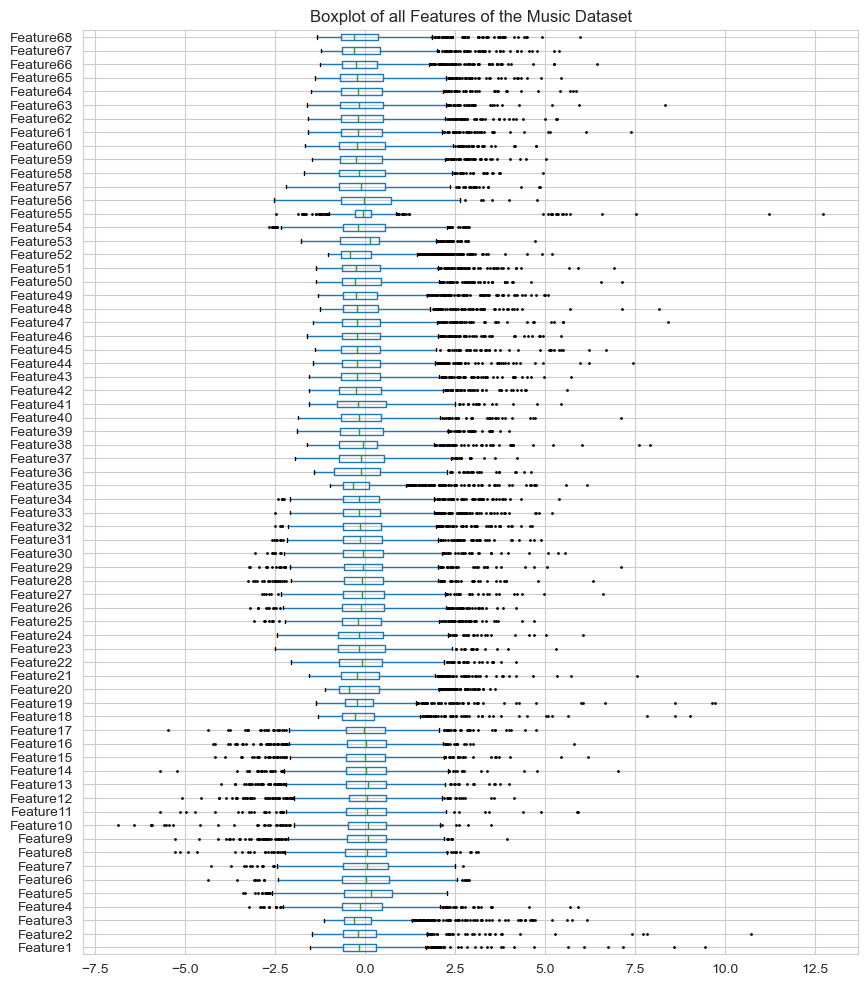

In [176]:
plt.figure(figsize=(10, 12))
music_origin_gdf.drop(['Latitude', 'Longitude', 'geometry', 'iso3',
                        'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                        'french_shor'],axis=1).boxplot(vert=False,
                                                       flierprops={'marker': 'o', 'markersize': 1})

plt.title("Boxplot of all Features of the Music Dataset")
plt.savefig('./images/07_Boxplot_68Features.png')

There are alot of features, thus it could be an idea, to make a Principle Component Analysis to reduce the number of features.

# Preprocessing

In [177]:
#make PCA:
scaler = preprocessing.StandardScaler()
music_origin_gdf_scaled = scaler.fit_transform(music_origin_gdf.drop(['Latitude', 'Longitude', 'geometry', 'iso3',
                                                                      'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                                                                      'french_shor'],axis=1))
nums = np.arange(68)
var_ratio = []
for num in nums:
    pca = PCA(n_components=num).fit(music_origin_gdf_scaled)
    var_ratio.append(np.sum(pca.explained_variance_ratio_))

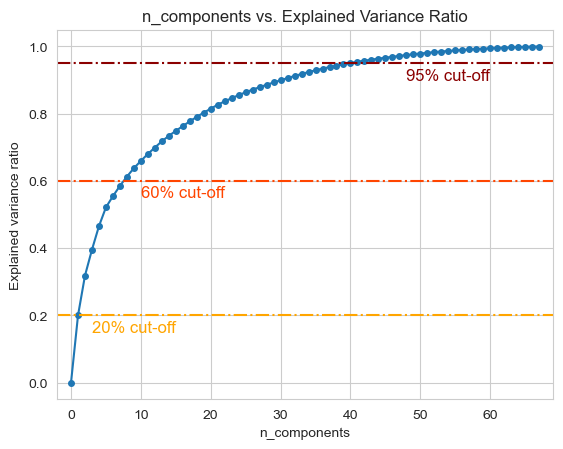

In [178]:
plt.plot(nums,var_ratio,marker='o',markersize = 4)
plt.xlim(-2,69)
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')
plt.axhline(y=0.95, color='darkred', linestyle='-.')
plt.text(48, 0.9, '95% cut-off', color = 'darkred', fontsize=12)
plt.axhline(y=0.6, color='orangered', linestyle='-.')
plt.text(10, 0.55, '60% cut-off ', color = 'orangered', fontsize=12)
plt.axhline(y=0.2, color='orange', linestyle='-.')
plt.text(3, 0.15, '20% cut-off', color = 'orange', fontsize=12)
plt.savefig('./images/08_PCA_n_comp_vs_variance3.png')

In [179]:
music_origin_gdf_filtered = music_origin_gdf_filtered.merge(music_origin_gdf["iso3"],on = "iso3")
music_origin_gdf_filtered["iso3"].unique()

array(['DZA', 'JAM', 'BLZ', 'MAR', 'TUR', 'LTU', 'UZB', 'CPV', 'ITA',
       'IRN', 'ETH', 'KGZ', 'GBR', 'SEN', 'GRC', 'IDN', 'PAK', 'EGY',
       'IND', 'THA', 'AUS', 'TWN', 'BRA', 'KHM', 'GEO', 'CHN', 'ROU',
       'TZA', 'MMR', 'JPN', 'MLI', 'ALB', 'KEN'], dtype=object)

Okay, we choose the 95% cut-off beacuse then we have 95% of the variance explained, which is quite good.

Number of components to reach 95% cutoff: 41
Number of components to reach 60% cutoff: 9
Number of components to reach 20% cutoff: 3


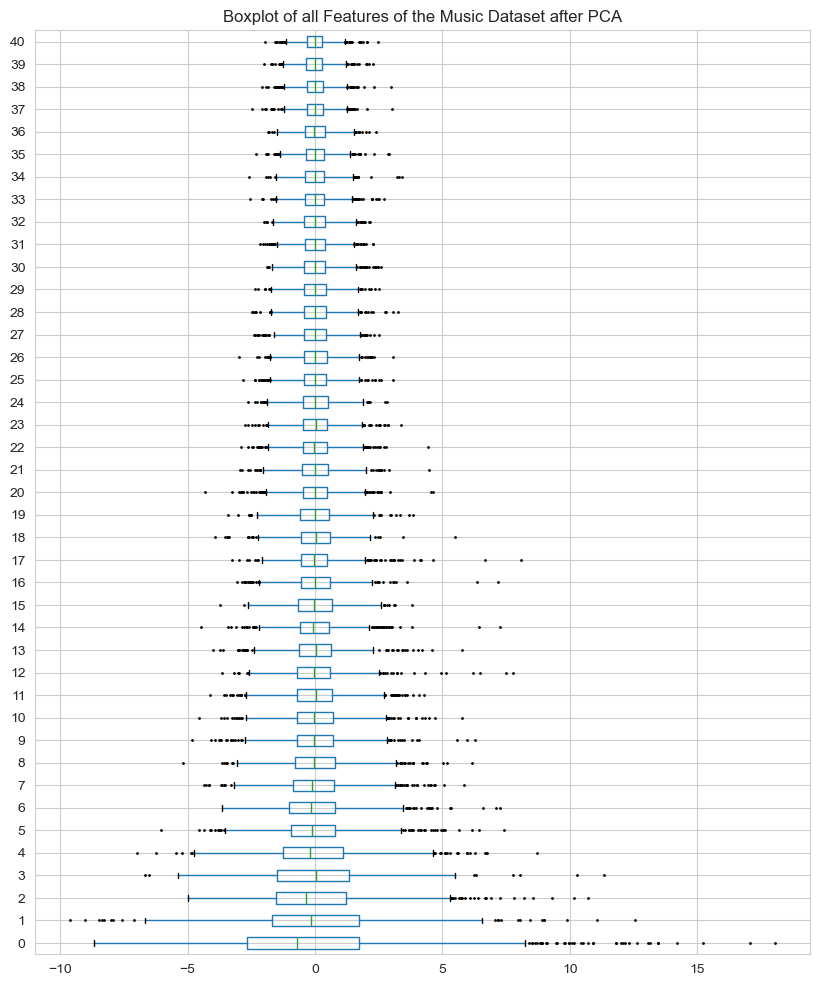

In [180]:
def get_num_components(percent,var_ratio = var_ratio):
    num_components_XX_percent = np.argmax(np.array(var_ratio) >= percent/100) + 1
    #print(f"Number of components to reach {percent}% cutoff: {num_components_XX_percent}")
    return num_components_XX_percent

print(f"Number of components to reach 95% cutoff: {get_num_components(95)}")
print(f"Number of components to reach 60% cutoff: {get_num_components(60)}")
print(f"Number of components to reach 20% cutoff: {get_num_components(20)}")

#make PCA with 95% cutoff
music_origin_pca= pd.DataFrame(PCA(n_components=get_num_components(95)).fit_transform(music_origin_gdf_scaled))
music_origin_gdf_pca = music_origin_pca.merge(music_origin_gdf.loc[:,['Latitude', 'Longitude', 'iso3',
                                                                          'status', 'color_code', 'name', 'continent', 'region', 'iso_3166_1_',
                                                                          'french_shor']], left_index=True, right_index=True)


plt.figure(figsize=(10, 12))
music_origin_pca.boxplot(vert=False, flierprops={'marker': 'o', 'markersize': 1})

plt.title("Boxplot of all Features of the Music Dataset after PCA")
plt.savefig('./images/09_Boxplot_68Features_PCA.png')


# Clustering

To make this problem to a classification problem, we have to define clusters in order to classify the music samples

## Manual Clustering (geographic boundaries made by humans)

In [181]:
#By region
gdf_regions = gdf_bondaries.dissolve(by='region')
gdf_regions["region"] = gdf_regions.index
gdf_regions1 = gdf_regions[gdf_regions["region"].isin(music_origin_gdf_pca.region.unique())]

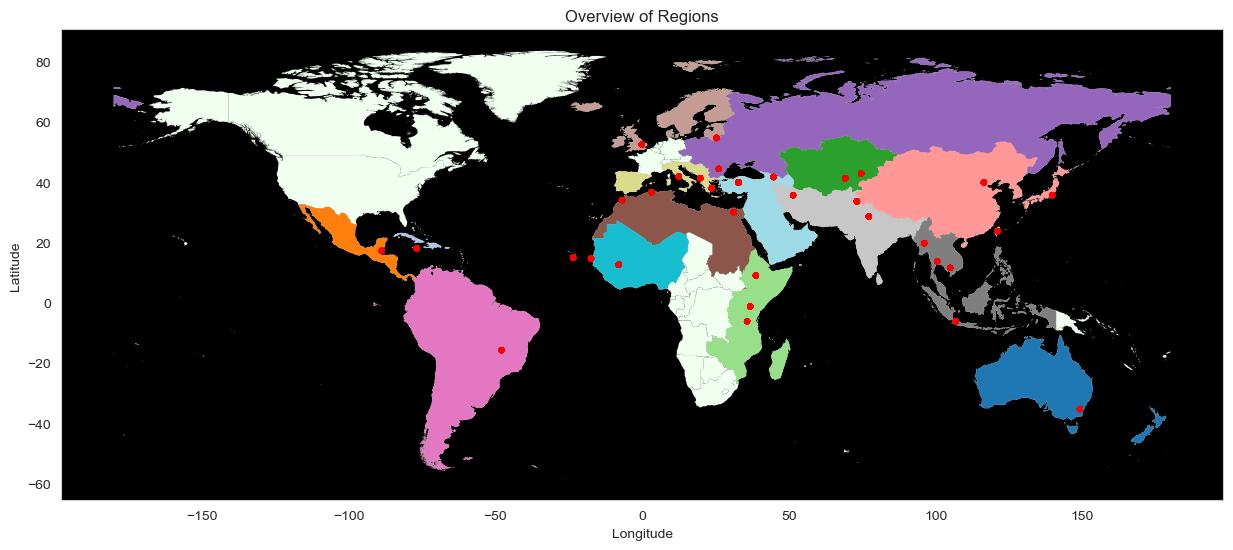

In [182]:
plt.figure(figsize=(15,10))
gdf_bondaries.plot(ax=plt.gca(), color = "honeydew",edgecolor = "none")
gdf_regions1.plot(ax=plt.gca(), column='region', cmap="tab20", alpha=1, legend=False, label='World Regions',edgecolor = "none")
plt.scatter(music_origin_data["Longitude"], music_origin_data["Latitude"], s=20, color = "red",label = 'Music samples',edgecolor = "none")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().set_facecolor("black")
plt.grid(False)
plt.title("Overview of Regions")
plt.savefig('./images/10_Clustering_region.png')

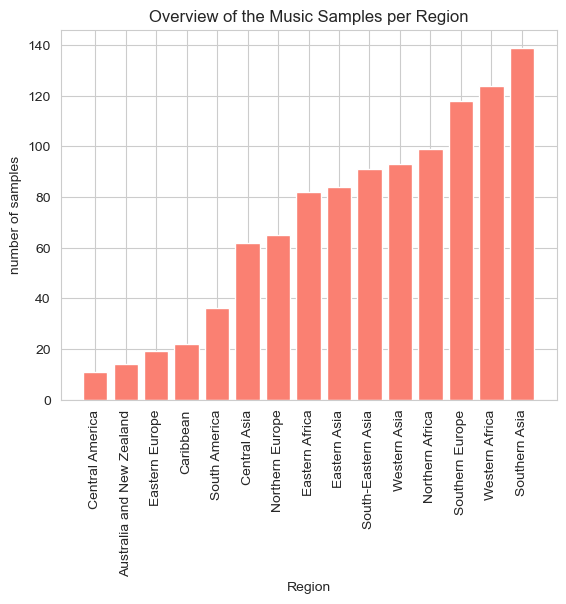

In [183]:
per_region = music_origin_gdf_pca.groupby('region').nunique().reset_index().sort_values(1)
plt.bar(per_region["region"],per_region[1], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per Region")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.show()


music_origin_gdf_pca_manual = music_origin_gdf_pca.copy()
music_origin_gdf_pca_manual["Cluster"] = music_origin_gdf_pca_manual["region"]

As seen here, we can see that the clusters are not equally distributed, which can lead to a false good prediction, because the chances that it lies in southern Asia is about the same. We try now to DBSCAN the points to clusters.

## Automatic Clustering (DBScan Method)

In [184]:
# Standardize the data
scaler = preprocessing.StandardScaler()
scaled_data = scaler.fit_transform(music_origin_gdf_pca[["Longitude","Latitude"]])
dbscan = DBSCAN(eps=0.5, min_samples=2)  # You may need to adjust eps and min_samples
music_origin_gdf_pca_dbscan = music_origin_gdf_pca.copy()
music_origin_gdf_pca_dbscan["Cluster"] = dbscan.fit_predict(scaled_data)


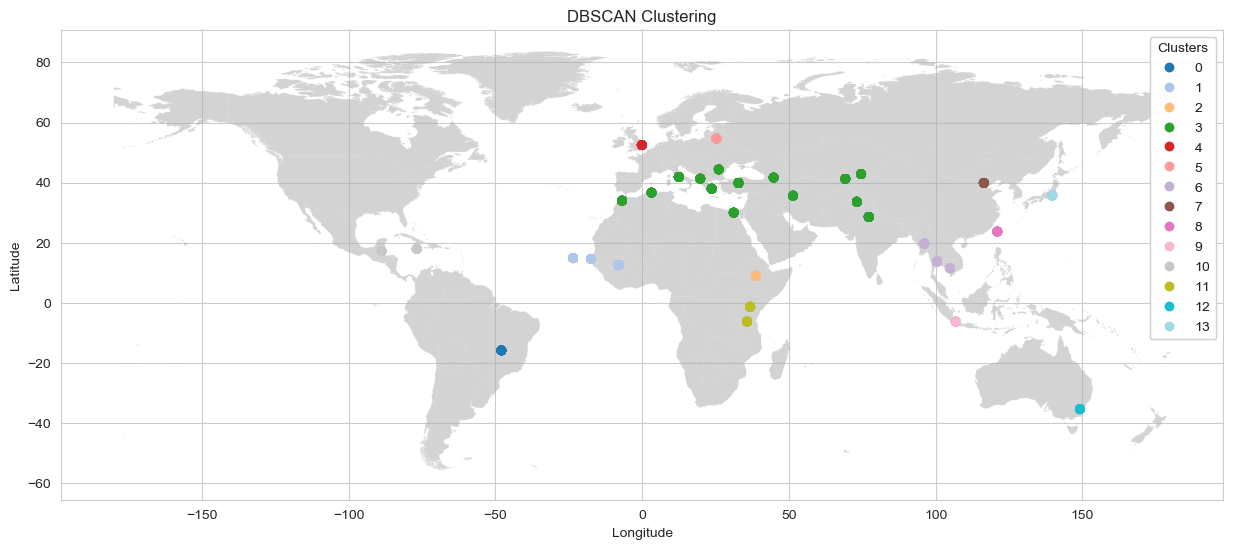

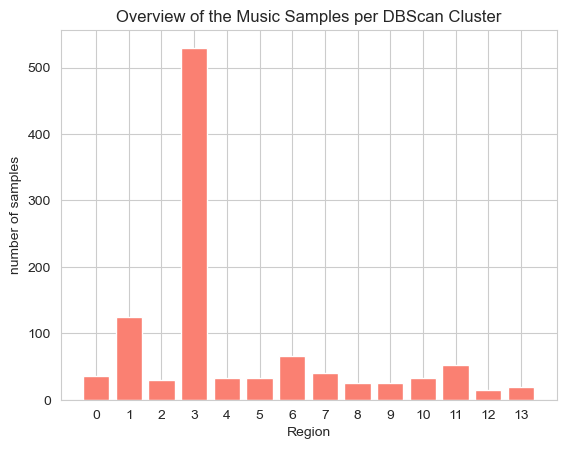

In [185]:
plt.figure(figsize=(15,10))
gdf_bondaries.plot(ax=plt.gca(), alpha=0.5, color = "darkgrey",edgecolor = "none")
scatter = plt.scatter(music_origin_gdf['Longitude'], music_origin_gdf['Latitude'], c=music_origin_gdf_pca_dbscan['Cluster'], cmap='tab20', label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering')
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)  # Add the legend back to the plot
plt.savefig('./images/11_DBSCAN_Clusters.png')
plt.show()

per_DBCluster = music_origin_gdf_pca_dbscan.groupby("Cluster").nunique()[0].reset_index().sort_values(0)
plt.bar(per_DBCluster["Cluster"],per_DBCluster[0], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per DBScan Cluster")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.xticks(per_DBCluster["Cluster"],rotation = "horizontal")
plt.savefig('./images/12_Overview_DBSCAN_Clusters.png')

plt.show()



# Classification internal data structure cluster

In [186]:
music_origin_gdf_pca_kmeans = music_origin_gdf_pca.copy()
selected_columns = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                    16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                    30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
selected_df = music_origin_gdf_pca_kmeans.iloc[:, selected_columns]

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(selected_df)
music_origin_gdf_pca_kmeans['Cluster'] = kmeans.labels_


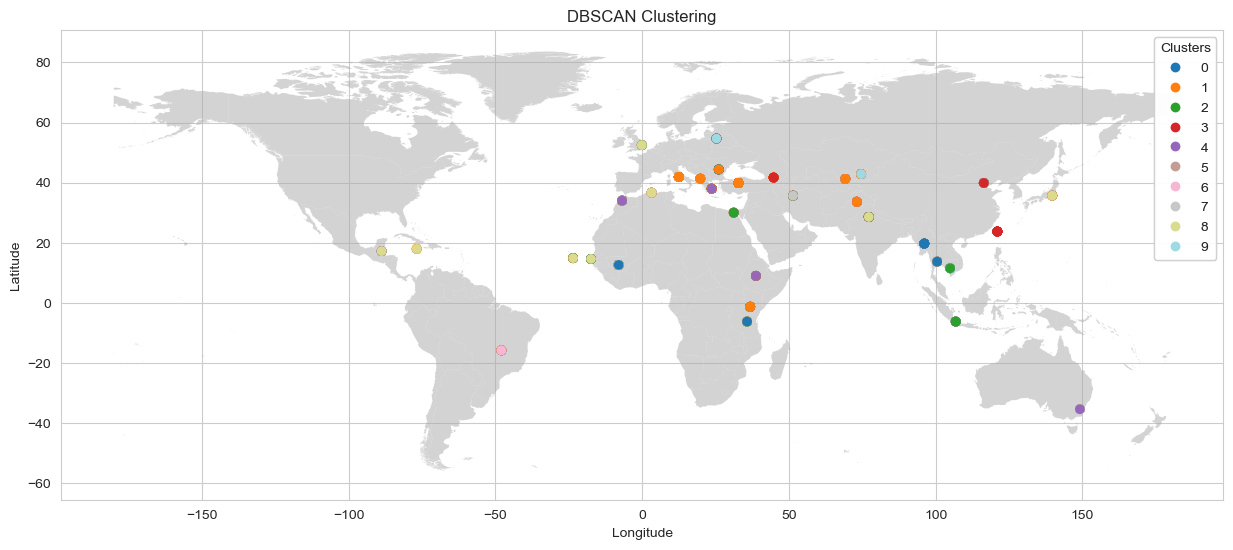

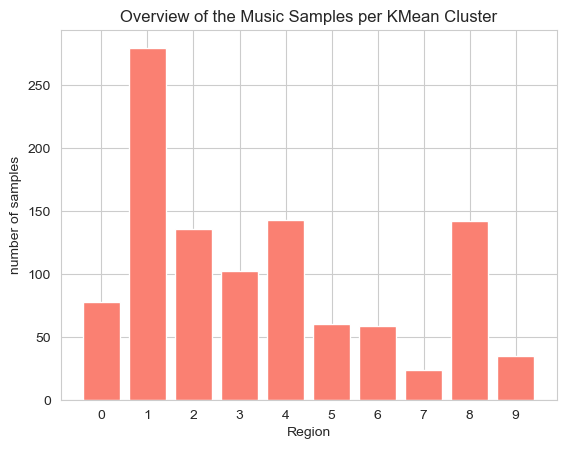

In [187]:
plt.figure(figsize=(15,10))
gdf_bondaries.plot(ax=plt.gca(), alpha=0.5, color = "darkgrey",edgecolor = "none")
scatter = plt.scatter(music_origin_gdf['Longitude'], music_origin_gdf['Latitude'], c=music_origin_gdf_pca_kmeans['Cluster'], cmap='tab20', label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering')
legend = plt.legend(*scatter.legend_elements(), title="Clusters")
plt.gca().add_artist(legend)  # Add the legend back to the plot
plt.savefig('./images/11_KMeans_clusters.png')
plt.show()

per_KmeanCluster = music_origin_gdf_pca_kmeans.groupby("Cluster").nunique()[0].reset_index().sort_values(0)
plt.bar(per_KmeanCluster["Cluster"],per_KmeanCluster[0], color = "salmon")
plt.xticks(rotation='vertical')
plt.title("Overview of the Music Samples per KMean Cluster")
plt.ylabel("number of samples")
plt.xlabel("Region")
plt.xticks(per_KmeanCluster["Cluster"],rotation = "horizontal")
plt.savefig('./images/12_Overview_DBSCAN_Clusters.png')

# Defining ML Technique

In [188]:
scorer = make_scorer(accuracy_score)
rfc = cb.CatBoostClassifier()
param_grid = {
    'iterations': [350],
    'depth': [6],
    'learning_rate': [0.2]
}

grid_search = GridSearchCV(
    estimator=rfc,
    param_grid=param_grid,
    scoring=scorer,
    cv=5,
    n_jobs=-1,
    refit='mse',
    verbose=10,
)

# Defining final matrix

In [189]:
final_matrix = pd.DataFrame(columns = ["score","ML_Clustering_Manual_PCA","ML_Clustering_DBScan_PCA","ML_Clustering_KMeans_PCA","ML_Clustering_Manual_SMOTE","ML_Clustering_DBScan_SMOTE","ML_Clustering_KMeans_SMOTE"],)
final_matrix["score"] = ['Accuracy', 'Precision', 'Recall', 'F1 Score (Weighted)']
final_matrix=final_matrix.set_index("score")

final_matrix

,ML_Clustering_Manual_PCA,ML_Clustering_DBScan_PCA,ML_Clustering_KMeans_PCA,ML_Clustering_Manual_SMOTE,ML_Clustering_DBScan_SMOTE,ML_Clustering_KMeans_SMOTE
score,,,,,,
Accuracy,NaN,NaN,NaN,NaN,NaN,NaN
Precision,NaN,NaN,NaN,NaN,NaN,NaN
Recall,NaN,NaN,NaN,NaN,NaN,NaN
F1 Score (Weighted),NaN,NaN,NaN,NaN,NaN,NaN


# Training (With PCA)

-----------------------------
Name of Clustering:
 ML_Clustering_Manual
Cluster
Southern Asia                139
Western Africa               124
Southern Europe              118
Northern Africa               99
Western Asia                  93
South-Eastern Asia            91
Eastern Asia                  84
Eastern Africa                82
Northern Europe               65
Central Asia                  62
South America                 36
Caribbean                     22
Eastern Europe                19
Australia and New Zealand     14
Central America               11
Name: count, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 2.6197511	total: 28ms	remaining: 9.77s
1:	learn: 2.5491396	total: 54.7ms	remaining: 9.53s
2:	learn: 2.4660781	total: 80ms	remaining: 9.26s
3:	learn: 2.3856252	total: 105ms	remaining: 9.07s
4:	learn: 2.3195152	total: 132ms	remaining: 9.1s
5:	learn: 2.2406562	total: 158ms	remaining: 9.04s
6:	learn: 2.1764910	total: 183ms	remaining

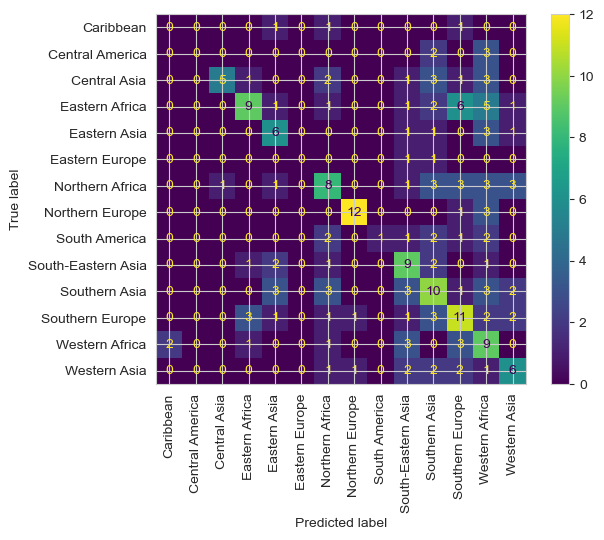

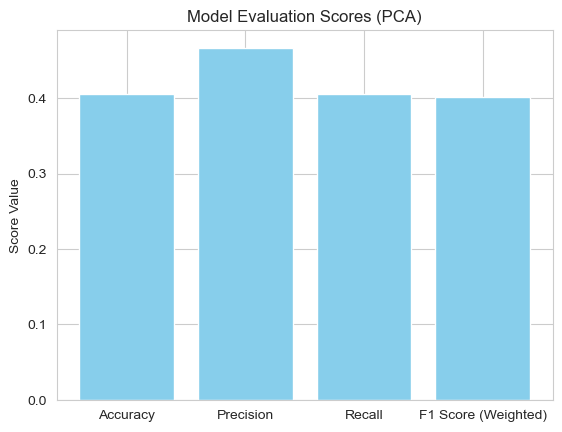

-----------------------------
-----------------------------
Name of Clustering:
 ML_Clustering_DBScan
Cluster
3     530
1     124
6      66
11     52
7      40
0      36
4      33
10     33
5      32
2      30
8      25
9      25
13     19
12     14
Name: count, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 2.3266163	total: 24.4ms	remaining: 8.5s
1:	learn: 2.1349909	total: 49.1ms	remaining: 8.54s
2:	learn: 2.0172655	total: 74.5ms	remaining: 8.61s
3:	learn: 1.9218369	total: 99.9ms	remaining: 8.64s
4:	learn: 1.8340541	total: 125ms	remaining: 8.6s
5:	learn: 1.7689573	total: 150ms	remaining: 8.61s
6:	learn: 1.6891179	total: 174ms	remaining: 8.51s
7:	learn: 1.6360914	total: 197ms	remaining: 8.41s
8:	learn: 1.5891046	total: 219ms	remaining: 8.31s
9:	learn: 1.5445438	total: 243ms	remaining: 8.27s
10:	learn: 1.4958687	total: 267ms	remaining: 8.23s
11:	learn: 1.4543906	total: 291ms	remaining: 8.2s
12:	learn: 1.4156353	total: 314ms	remaining: 8.14s
13:	learn: 

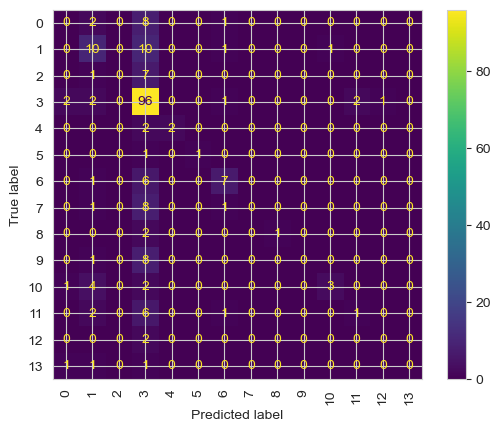

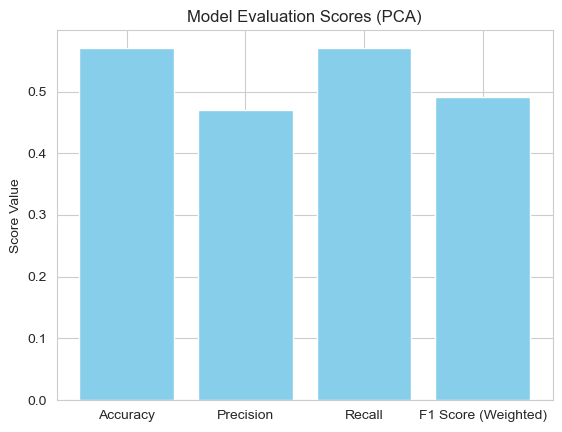

-----------------------------
-----------------------------
Name of Clustering:
 ML_Clustering_KMeans
Cluster
1    280
4    143
8    142
2    136
3    102
0     78
5     60
6     59
9     35
7     24
Name: count, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 1.8944752	total: 19.4ms	remaining: 6.77s
1:	learn: 1.6378485	total: 36.9ms	remaining: 6.42s
2:	learn: 1.4960904	total: 54.1ms	remaining: 6.25s
3:	learn: 1.3405838	total: 71.4ms	remaining: 6.17s
4:	learn: 1.1891101	total: 88.6ms	remaining: 6.11s
5:	learn: 1.0610705	total: 106ms	remaining: 6.06s
6:	learn: 0.9570853	total: 123ms	remaining: 6.02s
7:	learn: 0.8776998	total: 140ms	remaining: 5.97s
8:	learn: 0.8305850	total: 156ms	remaining: 5.93s
9:	learn: 0.7858565	total: 174ms	remaining: 5.9s
10:	learn: 0.7469024	total: 191ms	remaining: 5.89s
11:	learn: 0.7150745	total: 208ms	remaining: 5.86s
12:	learn: 0.6751208	total: 225ms	remaining: 5.84s
13:	learn: 0.6460611	total: 243ms	remaining: 5.82s
14:	lea

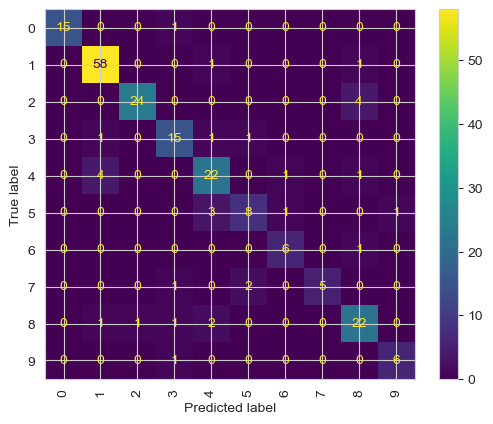

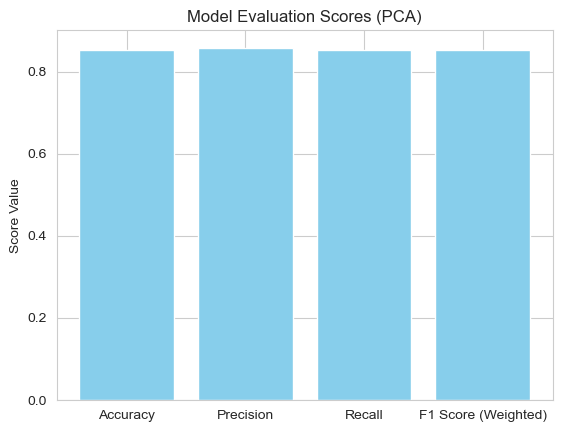

-----------------------------


In [190]:
#1. define the ML Technique:
names = ["ML_Clustering_Manual", "ML_Clustering_DBScan", "ML_Clustering_KMeans"]
num = 0
#2. define all Clustering methods (wihtout SMOTE)
ML_Clustering_Manual = music_origin_gdf_pca_manual.drop(['Latitude', 'Longitude',
                                                         'status', 'color_code', 'name', 'iso3', 'iso_3166_1_',
                                                         'french_shor','continent','region'],axis = 1)

ML_Clustering_DBScan = music_origin_gdf_pca_dbscan.drop(['Latitude', 'Longitude',
                                                         'status', 'color_code', 'name', 'iso3', 'iso_3166_1_',
                                                         'french_shor','continent','region'],axis = 1)


ML_Clustering_KMeans = music_origin_gdf_pca_kmeans.drop(['Latitude', 'Longitude',
                                                         'status', 'color_code', 'name', 'iso3', 'iso_3166_1_',
                                                         'french_shor','continent','region'],axis = 1)


#loop through all of them
for i in [ML_Clustering_Manual,ML_Clustering_DBScan,ML_Clustering_KMeans]:
    print(f"-----------------------------\nName of Clustering:\n {names[num]}")
    print(i["Cluster"].value_counts())
    start_time = datetime.now()
    X_train, X_test, y_train, y_test = train_test_split(i.drop("Cluster",axis = 1), i['Cluster'], test_size=0.2)
    
    grid_search.fit(X_train,y_train)
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    end_time = datetime.now()
    print(f'Finished in: {end_time-start_time}')
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Best Accuracy Score:", best_accuracy)


    y_pred = grid_search.best_estimator_.predict(X_test)
    f1_score(y_test,y_pred,average='weighted')
    
    ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test)
    plt.xticks(rotation=90)  # Set the desired rotation angle
    plt.show()
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    final_matrix.at["Accuracy", f"{names[num]}_PCA"] = accuracy
    final_matrix.at["Precision", f"{names[num]}_PCA"] = precision
    final_matrix.at["Recall", f"{names[num]}_PCA"] = recall
    final_matrix.at["F1 Score (Weighted)", f"{names[num]}_PCA"] = f1

    
    
    
    
    scores = [accuracy, precision, recall, f1]
    score_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score (Weighted)']
    
    plt.bar(score_names, scores, color='skyblue')
    plt.title('Model Evaluation Scores (PCA)')
    plt.ylabel('Score Value')
    plt.show()
    num +=1

    print("-----------------------------")

# With SMOTE

Cluster
Southern Asia                139
Western Africa               124
Southern Europe              118
Northern Africa               99
Western Asia                  93
South-Eastern Asia            91
Eastern Asia                  84
Eastern Africa                82
Northern Europe               65
Central Asia                  62
South America                 36
Caribbean                     22
Eastern Europe                19
Australia and New Zealand     14
Central America               11
Name: count, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 2.4964869	total: 28.2ms	remaining: 9.86s
1:	learn: 2.2557052	total: 55.2ms	remaining: 9.6s
2:	learn: 2.1615801	total: 82.9ms	remaining: 9.59s
3:	learn: 2.0367376	total: 110ms	remaining: 9.52s
4:	learn: 1.9411817	total: 137ms	remaining: 9.43s
5:	learn: 1.8508271	total: 164ms	remaining: 9.38s
6:	learn: 1.7682099	total: 191ms	remaining: 9.34s
7:	learn: 1.6918496	total: 217ms	remaining: 9.27s
8:	learn: 

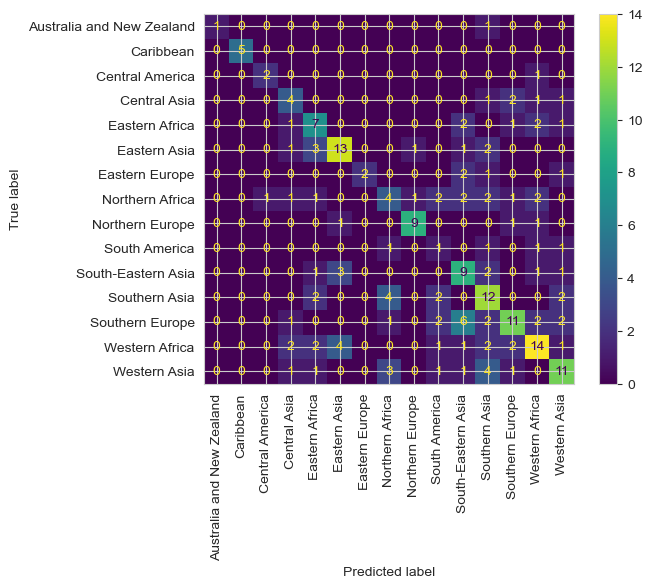

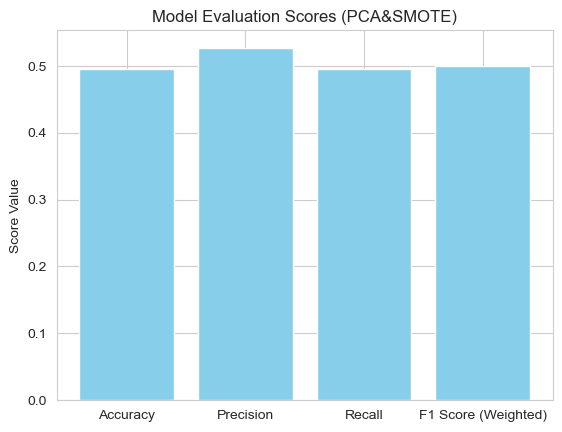

-----------------------------
Cluster
3     530
1     124
6      66
11     52
7      40
0      36
4      33
10     33
5      32
2      30
8      25
9      25
13     19
12     14
Name: count, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 2.2000873	total: 27.7ms	remaining: 9.68s
1:	learn: 1.9190026	total: 54ms	remaining: 9.4s
2:	learn: 1.7428579	total: 81.6ms	remaining: 9.43s
3:	learn: 1.5964950	total: 109ms	remaining: 9.45s
4:	learn: 1.4741196	total: 136ms	remaining: 9.35s
5:	learn: 1.3809134	total: 162ms	remaining: 9.26s
6:	learn: 1.2649659	total: 187ms	remaining: 9.16s
7:	learn: 1.1628177	total: 213ms	remaining: 9.1s
8:	learn: 1.0861904	total: 239ms	remaining: 9.05s
9:	learn: 1.0159685	total: 265ms	remaining: 9.02s
10:	learn: 0.9470913	total: 292ms	remaining: 9s
11:	learn: 0.8938052	total: 318ms	remaining: 8.96s
12:	learn: 0.8351018	total: 344ms	remaining: 8.91s
13:	learn: 0.7877077	total: 370ms	remaining: 8.87s
14:	learn: 0.7425512	total: 396ms	rem

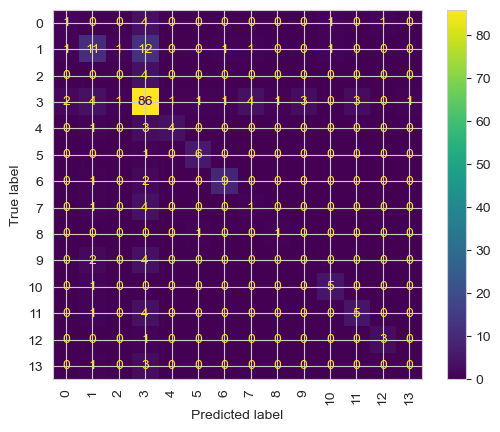

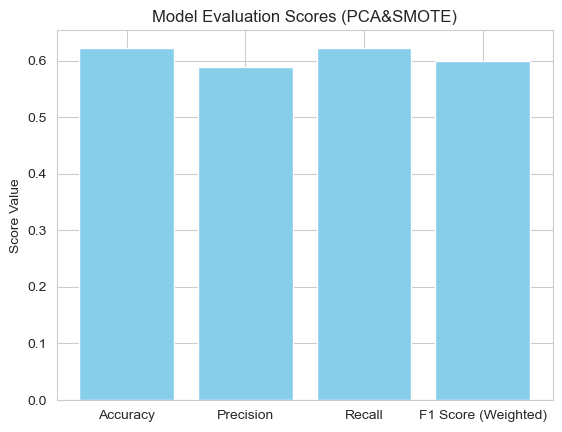

-----------------------------
Cluster
1    280
4    143
8    142
2    136
3    102
0     78
5     60
6     59
9     35
7     24
Name: count, dtype: int64
Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 1.7020100	total: 18.9ms	remaining: 6.61s
1:	learn: 1.3807222	total: 37.5ms	remaining: 6.53s
2:	learn: 1.1649605	total: 55.6ms	remaining: 6.43s
3:	learn: 0.9845367	total: 72.7ms	remaining: 6.29s
4:	learn: 0.8594499	total: 90.3ms	remaining: 6.23s
5:	learn: 0.7731636	total: 108ms	remaining: 6.18s
6:	learn: 0.6949084	total: 125ms	remaining: 6.11s
7:	learn: 0.6282722	total: 142ms	remaining: 6.08s
8:	learn: 0.5849167	total: 160ms	remaining: 6.08s
9:	learn: 0.5392787	total: 178ms	remaining: 6.05s
10:	learn: 0.4942518	total: 195ms	remaining: 6.02s
11:	learn: 0.4647768	total: 213ms	remaining: 6s
12:	learn: 0.4272321	total: 231ms	remaining: 6s
13:	learn: 0.3982436	total: 249ms	remaining: 5.97s
14:	learn: 0.3788500	total: 267ms	remaining: 5.96s
15:	learn: 0.3591648	total: 285ms

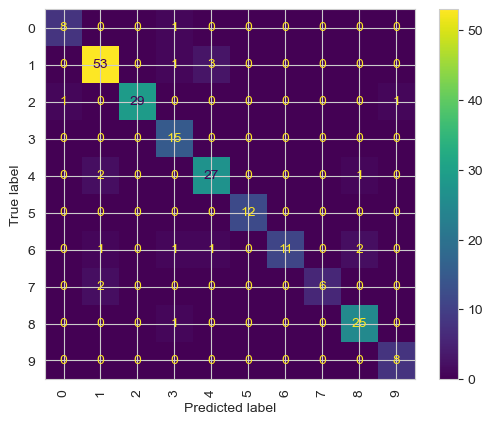

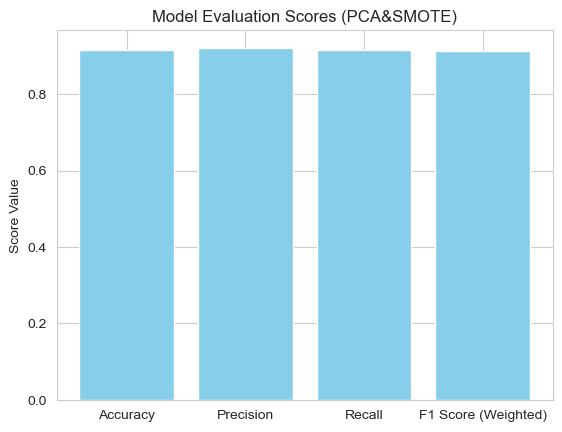

-----------------------------


In [191]:
num = 0

for i in [ML_Clustering_Manual,ML_Clustering_DBScan,ML_Clustering_KMeans]:    
    
    print(i["Cluster"].value_counts())
    start_time = datetime.now()
    X_train, X_test, y_train, y_test = train_test_split(i.drop("Cluster",axis = 1), i['Cluster'], test_size=0.2)
    smote = SMOTE(sampling_strategy='auto')
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    
    grid_search.fit(X_train_resampled,y_train_resampled)
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    end_time = datetime.now()
    print(f'Finished in: {end_time-start_time}')
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_
    print("Best Parameters:", best_params)
    print("Best Accuracy Score:", best_accuracy)

    y_pred = grid_search.best_estimator_.predict(X_test)
    f1_score(y_test,y_pred,average='weighted')
    ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test)
    plt.xticks(rotation=90)  # Set the desired rotation angle
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    final_matrix.at["Accuracy", f"{names[num]}_SMOTE"] = accuracy
    final_matrix.at["Precision", f"{names[num]}_SMOTE"] = precision
    final_matrix.at["Recall", f"{names[num]}_SMOTE"] = recall
    final_matrix.at["F1 Score (Weighted)", f"{names[num]}_SMOTE"] = f1


    scores = [accuracy, precision, recall, f1]
    score_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score (Weighted)']

    plt.bar(score_names, scores, color='skyblue')
    plt.title('Model Evaluation Scores (PCA&SMOTE)')
    plt.ylabel('Score Value')
    plt.show()
    num +=1

    print("-----------------------------")

# Presentation / Appendix / Visualisation for explanation

In [192]:
def download_video(url, output_path='./data/'):
    yt = YouTube(url)
    audio_stream = yt.streams.filter(only_audio=True).first()
    audio_stream.download(output_path)
    print(f"Video downloaded successfully to {output_path}")

#download_video(input("Enter the YouTube video URL: "))

# https://stackoverflow.com/questions/55081352/how-to-convert-mp4-to-mp3-using-python
from moviepy.editor import *
def MP4ToMP3(mp4, mp3): 
    FILETOCONVERT = AudioFileClip(mp4)
    FILETOCONVERT.write_audiofile(mp3)
    FILETOCONVERT.close()
VIDEO_FILE_PATH = r"C:\Users\claud\Documents\Studium\GEO871\data\Drums_youtube.mp4"
AUDIO_FILE_PATH =  r"C:\Users\claud\Documents\Studium\GEO871\data\Drums_youtube.mp3"
MP4ToMP3(VIDEO_FILE_PATH, AUDIO_FILE_PATH)    

MoviePy - Writing audio in C:\Users\claud\Documents\Studium\GEO871\data\Drums_youtube.mp3


MoviePy - Done.


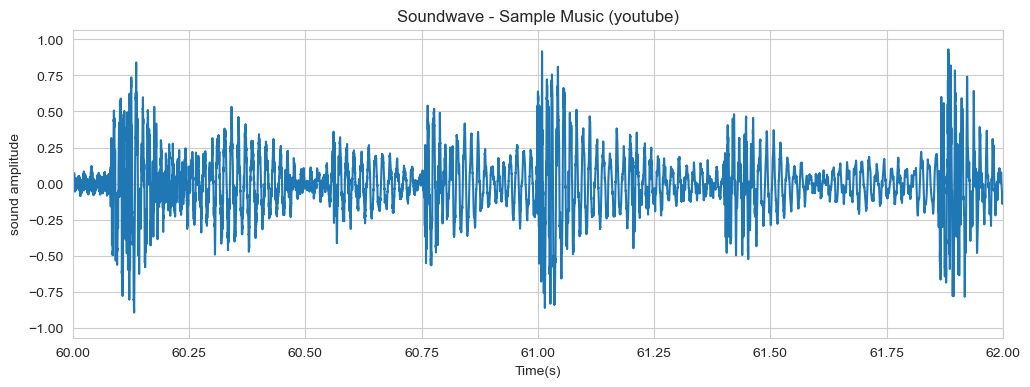

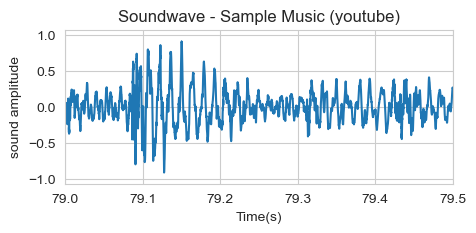

[0.161, 0.164, 0.159, 0.155, 0.148, 0.147, 0.141, 0.137, 0.136, 0.134, 0.135, 0.132, 0.126, 0.122, 0.118, 0.116, 0.116, 0.112, 0.112, 0.12, 0.121, 0.124, 0.126, 0.129, 0.136, 0.135, 0.141, 0.146, 0.15, 0.157, 0.161, 0.165, 0.17, 0.17, 0.175, 0.185, 0.183, 0.181, 0.183, 0.182, 0.195, 0.209, 0.193, 0.18, 0.189, 0.193, 0.186, 0.181, 0.185, 0.185]


In [193]:
def plot_wavelength(audio_file):
    # Load the audio file
    y, sr = librosa.load(audio_file)
    time = np.arange(0,len(y))/sr
    plt.figure(figsize=(12, 4))
    plt.plot(time,y)
    plt.xlim(60,62)
    plt.xlabel("Time(s)")
    plt.ylabel('sound amplitude')
    plt.title("Soundwave - Sample Music (youtube)")
    plt.savefig('./images/13_Soundwave_big.png')
    plt.show()

    plt.figure(figsize=(5, 2))
    plt.plot(time,y)
    plt.xlim(79,79.5)
    plt.xlabel("Time(s)")
    plt.ylabel('sound amplitude')
    plt.title("Soundwave - Sample Music (youtube)")
    plt.savefig('./images/14_Soundwave_small_2.png')
    plt.show()

    
    print(list(np.round(y[5000:5050], 3)))

plot_wavelength(r"C:\Users\claud\Documents\Studium\GEO871\data\Drums_youtube.mp3")

In [194]:
final_matrix

,ML_Clustering_Manual_PCA,ML_Clustering_DBScan_PCA,ML_Clustering_KMeans_PCA,ML_Clustering_Manual_SMOTE,ML_Clustering_DBScan_SMOTE,ML_Clustering_KMeans_SMOTE
score,,,,,,
Accuracy,0.40566,0.570755,0.853774,0.495283,0.622642,0.915094
Precision,0.466701,0.469776,0.857992,0.527057,0.588244,0.921617
Recall,0.40566,0.570755,0.853774,0.495283,0.622642,0.915094
F1 Score (Weighted),0.401476,0.491266,0.8529,0.499822,0.599756,0.914133
